In [1]:
import os
import json
import astropy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import Distance
from astropy.cosmology import Planck15
# pd.set_option('display.max_rows', 500)

model='2019'

def absmag(m, z):
    '''
    Converts apparent magnitude to absolute magnitude.
    
    Args:
        m (float): apparent magnitude
        z (float): redshift
    '''
    try:
        z = float(z)
    except ValueError:
        if type(z) == str:
            z = float(z.split('±')[0])
    if m is None or m is np.nan or z is None or z is np.nan:
        return np.nan
    else:
        if z==0:
            M = m
        elif z < 0:
            M = m
        else:
            try:
                d = Distance(unit=u.pc, z=float(z), allow_negative=True)
                M = m - 5 * np.log10(d/(10*u.pc)) + 5
            except:
                M = np.nan
        return M
absmag = np.vectorize(absmag)

import builtins
import time
import glob


time_start = time.time()


def read_lightcurve_file(filename: str):
    """
    Function to read in lightcurve file and create a dictionary containing the time (in days) at which the lightcurves 
    are evaluated and the corresponding values for different filters.
    """
    with open(filename, "r") as f:
        header = list(builtins.filter(None, f.readline().rstrip().strip("#").split(" ")))
    df = pd.read_csv(
        filename,
        delimiter=" ",
        comment="#",
        header=None,
        names=header,
        index_col=False,
    )
    df.rename(columns={"t[days]": "t"}, inplace=True)

    return df#.to_dict(orient="series")

time_start = time.time()
if model == '2019':
    bulla_grid_files = sorted(glob.glob("lcs_bulla_2019/lcs/*.dat"))
    if bulla_grid_files == []:
        bulla_grid_files = sorted(glob.glob("lcs_bulla_2019/*.dat"))
elif model == '2022':
    bulla_grid_files = sorted(glob.glob("lcs_bulla_2022/*.dat"))

# print(bulla_grid_files[0])


# print(type(bulla_grid_files[0]))
# print(len(bulla_grid_files))
bulla_grid_lightcurves = {filename: read_lightcurve_file(filename) for filename in list(bulla_grid_files)}
time_end = time.time()
print(f"Time taken to load lightcurves: {time_end - time_start:.2f} seconds")
bulla_grid_lightcurves

Time taken to load lightcurves: 1.02 seconds


{'lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3.0e+03_theta0.00_dMpc0.dat':        t    ztfg    ztfr    ztfi
 0    0.5 -14.803 -15.659 -15.706
 1    1.0 -13.030 -14.177 -14.614
 2    1.5 -12.212 -13.340 -13.856
 3    2.0 -11.445 -12.683 -13.234
 4    2.5 -10.663 -12.081 -12.714
 5    3.0  -9.854 -11.478 -12.242
 6    3.5  -9.044 -10.872 -11.768
 7    4.0  -8.290 -10.271 -11.287
 8    4.5  -7.536  -9.709 -10.826
 9    5.0  -6.781  -9.139 -10.383
 10   5.5  -6.178  -8.643  -9.959
 11   6.0  -5.473  -8.095  -9.526
 12   6.5  -4.912  -7.636  -9.127
 13   7.0  -4.200  -7.192  -8.776
 14   7.5  -3.654  -6.732  -8.378
 15   8.0  -3.335  -6.368  -8.055
 16   8.5  -2.779  -5.927  -7.685
 17   9.0  -2.323  -5.501  -7.378
 18   9.5  -1.814  -5.239  -7.077
 19  10.0  -1.175  -4.892  -6.754
 20  10.5  -0.964  -4.449  -6.450
 21  11.0  -0.332  -4.023  -6.127
 22  11.5  -0.163  -3.744  -5.821
 23  12.0   0.476  -3.380  -5.552
 24  12.5   1.047  -3.186  -5.309
 25  13.0   1.839  -2.631  -4.991
 26  1

In [2]:
reddening_dataframes = []
for filename, lightcurve in bulla_grid_lightcurves.items():
    lightcurve['reddening_g_r'] = lightcurve['ztfg'] - lightcurve['ztfr']
    lightcurve['reddening_g_i'] = lightcurve['ztfg'] - lightcurve['ztfi']
    lightcurve['t'] = lightcurve['t'].astype(float)
    lightcurve['obj_id'] = filename
    reddening_dataframes.append(lightcurve[['t', 'reddening_g_r', 'reddening_g_i', 'obj_id']])

combined_reddening_df = pd.concat(reddening_dataframes, ignore_index=True)

## get rid of early times
combined_reddening_df['t'] = combined_reddening_df['t'] - 1
combined_reddening_df = combined_reddening_df[combined_reddening_df['t'] >= 0]
display(combined_reddening_df)

,t,reddening_g_r,reddening_g_i,obj_id
1,0.0,1.147,1.584,lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3...
2,0.5,1.128,1.644,lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3...
3,1.0,1.238,1.789,lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3...
4,1.5,1.418,2.051,lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3...
5,2.0,1.624,2.388,lcs_bulla_2019/lcs/nph1.0e+06_mej0.01_phi15_T3...
...,...,...,...,...
65995,12.0,1.495,2.256,lcs_bulla_2019/lcs/nph1.0e+06_mej0.10_phi75_T9...
65996,12.5,1.511,2.292,lcs_bulla_2019/lcs/nph1.0e+06_mej0.10_phi75_T9...
65997,13.0,1.561,2.363,lcs_bulla_2019/lcs/nph1.0e+06_mej0.10_phi75_T9...
65998,13.5,1.614,2.426,lcs_bulla_2019/lcs/nph1.0e+06_mej0.10_phi75_T9...


In [3]:
percentiles_df = combined_reddening_df.groupby('t').agg(
    reddening_g_r_1=('reddening_g_r', lambda x: x.quantile(0.01)),
    reddening_g_r_50=('reddening_g_r', lambda x: x.quantile(0.50)),
    reddening_g_r_99=('reddening_g_r', lambda x: x.quantile(0.99)),
    reddening_g_i_1=('reddening_g_i', lambda x: x.quantile(0.01)),
    reddening_g_i_50=('reddening_g_i', lambda x: x.quantile(0.50)),
    reddening_g_i_99=('reddening_g_i', lambda x: x.quantile(0.99)),
    reddening_g_r_25=('reddening_g_r', lambda x: x.quantile(0.25)),
    reddening_g_i_25=('reddening_g_i', lambda x: x.quantile(0.25)),
    reddening_g_r_75=('reddening_g_r', lambda x: x.quantile(0.75)),
    reddening_g_i_75=('reddening_g_i', lambda x: x.quantile(0.75))
).reset_index()

display(percentiles_df)

,t,reddening_g_r_1,reddening_g_r_50,reddening_g_r_99,reddening_g_i_1,reddening_g_i_50,reddening_g_i_99,reddening_g_r_25,reddening_g_i_25,reddening_g_r_75,reddening_g_i_75
0,0.0,0.26892,0.7910,1.68003,-0.01501,1.1930,2.70102,0.60075,0.72100,1.08675,1.71825
1,0.5,0.28699,0.8505,1.99303,0.06498,1.3120,3.17700,0.65300,0.89375,1.19100,1.88125
2,1.0,0.30300,0.9200,2.25900,0.10499,1.4190,3.55407,0.70175,0.98000,1.32825,2.06200
3,1.5,0.32984,0.9860,2.49102,0.13991,1.4935,3.90209,0.73600,1.04200,1.46600,2.24825
4,2.0,0.33796,1.0510,2.66404,0.17688,1.5665,4.17900,0.77375,1.09575,1.60575,2.44800
5,2.5,0.34994,1.1050,2.84613,0.21579,1.6390,4.46800,0.81400,1.14900,1.73100,2.65025
6,3.0,0.36495,1.1555,3.08119,0.23888,1.7025,4.80600,0.84900,1.20100,1.85075,2.82025
7,3.5,0.39184,1.2060,3.25309,0.27893,1.7755,5.05200,0.88600,1.25100,1.96000,2.99225
8,4.0,0.39993,1.2545,3.36104,0.31174,1.8460,5.22122,0.91800,1.30000,2.06875,3.14725
9,4.5,0.42282,1.3040,3.50101,0.35183,1.9145,5.50606,0.94675,1.34875,2.15425,3.30025


In [4]:
df_gp = pd.read_csv('gp_objects(downsample).csv')
df_25 = df_gp[df_gp['obj_id']=='ZTF25abjmnps']
df_25['reddening_g_r'] = df_25['abs_mag_ztfg'] - df_25['abs_mag_ztfr']
df_25['reddening_error'] = np.sqrt(df_25['mag_error_ztfg']**2 + df_25['mag_error_ztfr']**2)
df_25

/var/folders/8_/ky643qs168ngjmhrpwcq1fdm0000gn/T/ipykernel_35296/4108564922.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_25['reddening_g_r'] = df_25['abs_mag_ztfg'] - df_25['abs_mag_ztfr']
/var/folders/8_/ky643qs168ngjmhrpwcq1fdm0000gn/T/ipykernel_35296/4108564922.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_25['reddening_error'] = np.sqrt(df_25['mag_error_ztfg']**2 + df_25['mag_error_ztfr']**2)


,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id,mjd_0,...,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi,t,rise,fade,reddening_g_r,reddening_error
37652,60905.188368,12.590232,9.093358,10.963429,0.368367,1.340095,0.659792,AT2025ulz,ZTF25abjmnps,60905.188368,...,-16.706969,0.065341,21.503189,-16.503913,0.160006,0.000000,n,y,-0.150218,0.072654
37653,60905.196471,12.586238,9.093839,10.957884,0.363200,1.327958,0.652419,AT2025ulz,ZTF25abjmnps,60905.188368,...,-16.706419,0.064643,21.503132,-16.503971,0.158548,0.008103,n,y,-0.150423,0.071836
37654,60905.204574,12.582020,9.094291,10.952144,0.358508,1.315843,0.645280,AT2025ulz,ZTF25abjmnps,60905.188368,...,-16.705850,0.063970,21.503078,-16.504025,0.157094,0.016206,n,y,-0.150628,0.071058
37655,60905.212677,12.577579,9.094717,10.946208,0.354281,1.303750,0.638381,AT2025ulz,ZTF25abjmnps,60905.188368,...,-16.705262,0.063320,21.503027,-16.504076,0.155643,0.024309,n,y,-0.150833,0.070319
37656,60905.220780,12.572916,9.095117,10.940075,0.350502,1.291679,0.631726,AT2025ulz,ZTF25abjmnps,60905.188368,...,-16.704653,0.062695,21.502979,-16.504123,0.154195,0.032412,n,y,-0.151039,0.069619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38647,60913.250852,3.143694,9.806161,7.127932,0.115217,0.340238,0.728066,AT2025ulz,ZTF25abjmnps,60905.188368,...,-16.239511,0.110900,21.421252,-16.585850,0.037671,8.062484,n,y,0.888808,0.117823
38648,60913.258955,3.161257,9.826886,7.146532,0.115187,0.342336,0.736882,AT2025ulz,ZTF25abjmnps,60905.188368,...,-16.242341,0.111951,21.418960,-16.588142,0.037823,8.070587,n,y,0.885589,0.118735
38649,60913.267058,3.178820,9.847333,7.164981,0.116439,0.344971,0.745716,AT2025ulz,ZTF25abjmnps,60905.188368,...,-16.245140,0.113001,21.416703,-16.590399,0.038035,8.078690,n,y,0.882373,0.119795
38650,60913.275161,3.196376,9.867496,7.183280,0.119048,0.348165,0.754567,AT2025ulz,ZTF25abjmnps,60905.188368,...,-16.247910,0.114051,21.414483,-16.592620,0.038309,8.086793,n,y,0.879162,0.121008


In [5]:

#df_IIb = df_gp[(df_gp['type'] == 'IIb') | (df_gp['type'] == 'IIb')]
df_II = df_gp[(df_gp['type'] == 'II') | (df_gp['type'] == 'IIP') | (df_gp['type'] == 'IIn')]
df_II = df_II[df_II['rise'] == 'n']
df_IIb = df_gp[df_gp['type'] == 'IIb']
df_IIb = df_IIb[df_IIb['obj_id'] != 'ZTF21aaabrpu']
df_IIb = df_IIb[df_IIb['rise'] == 'n']
display(df_IIb), display(df_II);

,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id,mjd_0,...,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi,t,rise,fade
2890,59131.510648,1076.411282,NaN,1225.326998,271.011678,NaN,55.489613,IIb,ZTF19aanbpus,59131.510648,...,0.273359,16.179370,-17.062804,0.049168,NaN,NaN,NaN,0.000000,n,y
2891,59131.559736,1075.258727,NaN,1224.184428,270.647139,NaN,55.454968,IIb,ZTF19aanbpus,59131.510648,...,0.273284,16.180383,-17.061791,0.049183,NaN,NaN,NaN,0.049088,n,y
2892,59131.608824,1074.092552,NaN,1223.020870,270.288418,NaN,55.504258,IIb,ZTF19aanbpus,59131.510648,...,0.273218,16.181415,-17.060758,0.049274,NaN,NaN,NaN,0.098176,n,y
2893,59131.657912,1072.912768,NaN,1221.836469,269.935477,NaN,55.636085,IIb,ZTF19aanbpus,59131.510648,...,0.273162,16.182467,-17.059706,0.049439,NaN,NaN,NaN,0.147264,n,y
2894,59131.707000,1071.719385,NaN,1220.631366,269.588276,NaN,55.848700,IIb,ZTF19aanbpus,59131.510648,...,0.273114,16.183539,-17.058635,0.049677,NaN,NaN,NaN,0.196352,n,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35141,60257.038085,102.535658,162.687342,141.308493,6.016011,8.758817,5.723178,IIb,ZTF23abobwsd,60249.263796,...,0.063703,18.524579,-16.648166,0.043974,18.371616,-16.801130,0.058454,7.774289,n,y
35142,60257.084087,102.448160,162.580093,141.256168,5.976009,8.803420,5.687035,IIb,ZTF23abobwsd,60249.263796,...,0.063333,18.524981,-16.647764,0.043712,18.372332,-16.800414,0.058791,7.820290,n,y
35143,60257.130088,102.365644,162.481251,141.218951,5.935332,8.846045,5.652083,IIb,ZTF23abobwsd,60249.263796,...,0.062953,18.525268,-16.647478,0.043455,18.372992,-16.799754,0.059111,7.866292,n,y
35144,60257.176090,102.288007,162.390873,141.197038,5.894158,8.886673,5.618559,IIb,ZTF23abobwsd,60249.263796,...,0.062564,18.525436,-16.647309,0.043204,18.373596,-16.799150,0.059416,7.912294,n,y


,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id,mjd_0,...,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi,t,rise,fade
4118,58653.236875,166.488070,136.493788,146.600523,13.527701,10.204398,11.137441,II,ZTF19abacxod,58653.236875,...,0.088220,18.484661,-16.010504,0.082485,18.562218,-15.932947,0.081171,0.000000,n,y
4119,58653.275874,165.718060,136.194841,146.107168,13.254195,10.153644,10.866155,II,ZTF19abacxod,58653.236875,...,0.086838,18.488321,-16.006844,0.080747,18.564598,-15.930567,0.080944,0.038999,n,y
4120,58653.314873,164.940999,135.895329,145.615054,12.984712,10.116319,10.599131,II,ZTF19abacxod,58653.236875,...,0.085473,18.491984,-16.003181,0.079029,18.566989,-15.928176,0.080824,0.077998,n,y
4121,58653.353872,164.156834,135.595323,145.124287,12.719437,10.092061,10.336707,II,ZTF19abacxod,58653.236875,...,0.084127,18.495650,-15.999515,0.077333,18.569388,-15.925777,0.080809,0.116997,n,y
4122,58653.392871,163.365512,135.294892,144.634973,12.458561,10.080456,10.079252,II,ZTF19abacxod,58653.236875,...,0.082800,18.499317,-15.995848,0.075662,18.571796,-15.923369,0.080895,0.155996,n,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36227,60295.003634,30.110402,NaN,33.545705,3.697900,NaN,10.573518,II,ZTF23abtycgb,60292.165266,...,0.133341,20.085908,-14.698438,0.342221,NaN,NaN,NaN,2.838368,n,y
36228,60295.038676,30.393741,NaN,33.538721,3.716783,NaN,10.979076,II,ZTF23abtycgb,60292.165266,...,0.132772,20.086134,-14.698212,0.355421,NaN,NaN,NaN,2.873410,n,y
36229,60295.073717,30.676657,NaN,33.543391,3.752542,NaN,11.385125,II,ZTF23abtycgb,60292.165266,...,0.132813,20.085983,-14.698363,0.368515,NaN,NaN,NaN,2.908451,n,y
36230,60295.108759,30.957904,NaN,33.559190,3.811358,NaN,11.791480,II,ZTF23abtycgb,60292.165266,...,0.133670,20.085471,-14.698874,0.381488,NaN,NaN,NaN,2.943493,n,y


(-0.5, 3.0)

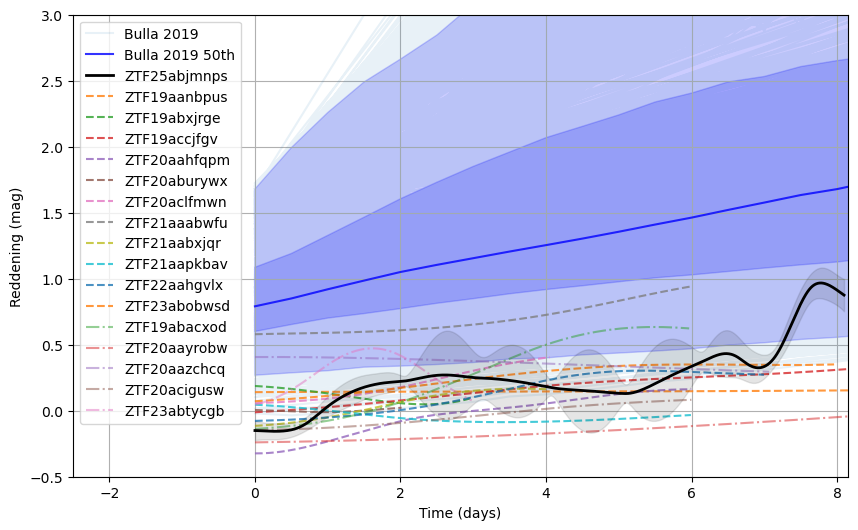

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
## plot combined_reddening_df as a line plot
ax.plot(combined_reddening_df['t'], combined_reddening_df['reddening_g_r'], label='Bulla 2019', alpha=0.1)
ax.plot(percentiles_df['t'], percentiles_df['reddening_g_r_50'], label='Bulla 2019 50th', color='blue', alpha=0.8)
# ax.plot(percentiles_df['t'], percentiles_df['reddening_g_r_1'], label='g-r 1st percentile', color='blue', alpha=0.5)
# ax.plot(percentiles_df['t'], percentiles_df['reddening_g_r_99'], label='g-r 99th percentile', color='blue', alpha=0.5)
ax.fill_between(percentiles_df['t'], percentiles_df['reddening_g_r_1'], percentiles_df['reddening_g_r_99'], color='blue', alpha=0.2)
ax.fill_between(percentiles_df['t'], percentiles_df['reddening_g_r_25'], percentiles_df['reddening_g_r_75'], color='blue', alpha=0.2)


ax.plot(df_25['t'], df_25['reddening_g_r'], label='ZTF25abjmnps', color='black', alpha=1, zorder=1000, linewidth=2)
ax.fill_between(df_25['t'], df_25['reddening_g_r'] - df_25['reddening_error'], df_25['reddening_g_r'] + df_25['reddening_error'], color='black', alpha=0.1, zorder=999)

## reddening for each of the SN in df_IIb and df_II
for obj in pd.concat([df_IIb, df_II])['obj_id'].unique():
    df_obj = pd.concat([df_IIb, df_II])[pd.concat([df_IIb, df_II])['obj_id'] == obj]
    #display(df_obj)
    #df_obj = df_obj[~df_obj['mag_error_ztfg'].isna()]
    #df_obj = df_obj[~df_obj['mag_error_ztfr'].isna()]   
    df_obj['reddening_g_r'] = df_obj['abs_mag_ztfg'] - df_obj['abs_mag_ztfr']
    df_obj['reddening_error'] = np.sqrt(df_obj['mag_error_ztfg']**2 + df_obj['mag_error_ztfr']**2)
    #ax.fill_between(df_obj['t'], df_obj['reddening_g_r'] - df_obj['reddening_error'], df_obj['reddening_g_r'] + df_obj['reddening_error'], alpha=0.1)
    ax.plot(df_obj['t'], df_obj['reddening_g_r'], label=f'{obj}', alpha=0.8, linestyle='--') if obj in df_IIb['obj_id'].unique() else ax.plot(df_obj['t'], df_obj['reddening_g_r'], label=f'{obj}', alpha=0.5, linestyle='dashdot')

#ax.plot(combined_reddening_df['t'], combined_reddening_df['reddening_g_i'], label='g-i', alpha=0.5)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Reddening (mag)')
ax.legend()
ax.grid()
ax.set_xlim(-2.5,8.15)
ax.set_ylim(-0.5,3)

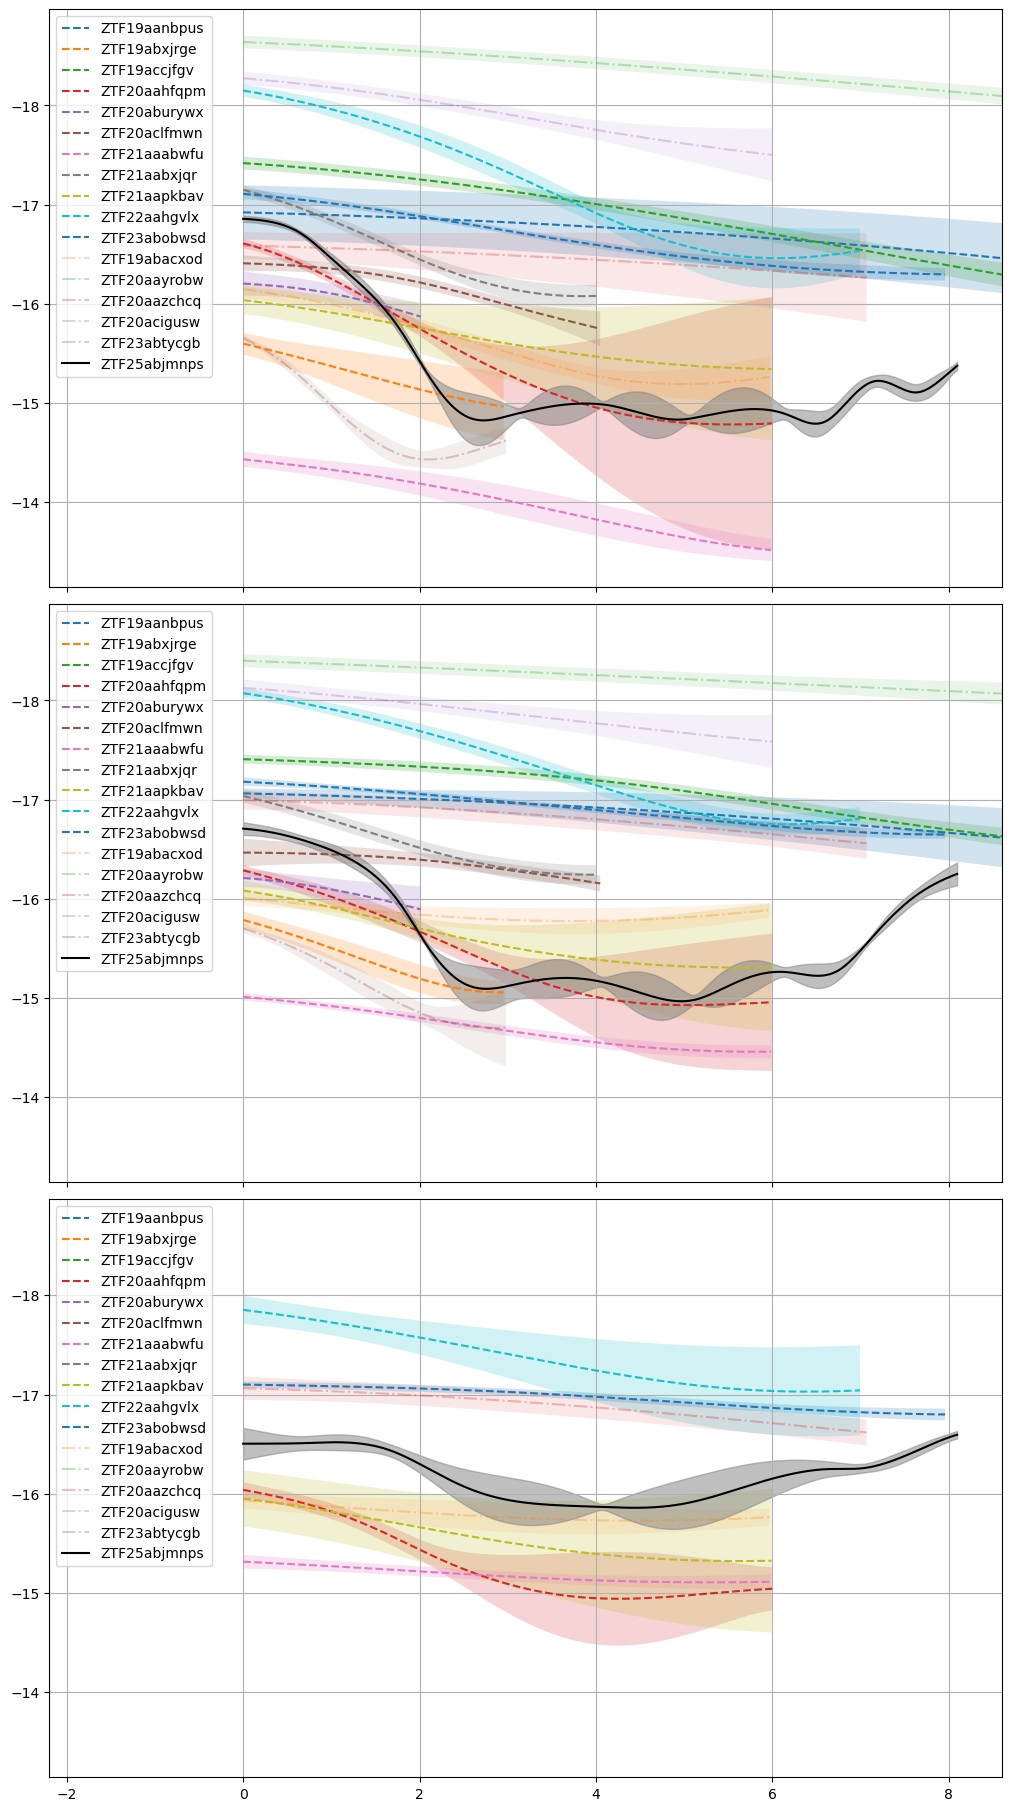

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 18), sharex=True, sharey=True, constrained_layout=True)
for obj_id in df_IIb['obj_id'].unique():
    df_obj = df_IIb[df_IIb['obj_id'] == obj_id]
    for idx, filt in enumerate(['ztfg', 'ztfr', 'ztfi']):
        if not df_obj.empty:
            ax[idx].plot(df_obj['t'], df_obj[f'abs_mag_{filt}'], label=obj_id, linestyle='--')
            ax[idx].fill_between(df_obj['t'], df_obj[f'abs_mag_{filt}'] - df_obj[f'mag_error_{filt}'], df_obj[f'abs_mag_{filt}'] + df_obj[f'mag_error_{filt}'], alpha=0.2,)
            
for obj_id in df_II['obj_id'].unique():
    df_obj = df_II[df_II['obj_id'] == obj_id]
    for idx, filt in enumerate(['ztfg', 'ztfr', 'ztfi']):
        if not df_obj.empty:
            ax[idx].plot(df_obj['t'], df_obj[f'abs_mag_{filt}'], label=obj_id, alpha=0.3, linestyle='dashdot')
            ax[idx].fill_between(df_obj['t'], df_obj[f'abs_mag_{filt}'] - df_obj[f'mag_error_{filt}'], df_obj[f'abs_mag_{filt}'] + df_obj[f'mag_error_{filt}'], alpha=0.1,)

for idx, filt in enumerate(['ztfg', 'ztfr', 'ztfi']):
    ax[idx].plot(df_25['t'], df_25[f'abs_mag_{filt}'], label='ZTF25abjmnps', alpha=1, color='black')
    ax[idx].fill_between(df_25['t'], df_25[f'abs_mag_{filt}'] - df_25[f'mag_error_{filt}'], df_25[f'abs_mag_{filt}'] + df_25[f'mag_error_{filt}'], alpha=0.5, color='gray')

[ax[idx].grid() for idx in range(3)]
[ax[idx].legend(loc='upper left') for idx in range(3)]
ax[0].set_xlim(-2.2,8.6)
ax[0].invert_yaxis()

